<a href="https://colab.research.google.com/github/abhinavgairola/Lending_Club_Project/blob/master/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Machine learning and encoding of categorical data

In [1]:
#from google.colab import files

#uploaded = files.upload()

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install pycaret

In [4]:
#from pandas_profiling import ProfileReport
import matplotlib.pyplot as mp
from collections import Counter
import math
import scipy.stats as ss
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import plotly as pf
import numpy as np
import math
#.figure_factory as ff
import seaborn as sns
import plotly.express as px
from collections import Counter
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import iplot, init_notebook_mode,plot
init_notebook_mode()
from urllib.request import urlopen
import json
from plotly.colors import n_colors
cm = sns.light_palette("green", as_cmap=True)
with open('/content/drive/My Drive/geoson-counties-fips.json') as json_:#urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(json_)
#from pycaret.classification import *
from pycaret.classification import *

In [5]:
def additive_smoothing(df, by, on, m):
    """ computes additive smoothing or Laplace smoothing
    @In, dataframe
    @In, by--feature to groupby
    @In, on-- target feature
    @In , m-- weight to be given to the global mean
    @Out, Laplace smoothed means
    """
    global_mean_target = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * global_mean_target) / (counts + m)
    return smooth#df[by].map(smooth)

In [6]:
def check_greater(by,on,df,count):
    """ The function checks the number of counts of a particular category in a categoricalfeature"""
    
    return Counter(list((df.groupby(by)[on].count().apply(lambda x: x if x>count else None).notnull().astype(int))))

In [7]:
df_dict = pd.read_csv('/content/drive/My Drive/Lending_club_dictionary.csv',encoding='ISO-8859-1')

In [8]:
df = pd.read_csv('/content/drive/My Drive/Lending_Club_clean.csv',chunksize=100000,low_memory=False)
dataframe = pd.concat(df)       

### Till now I haven't considered the outliers--This can create some problems for the machine learning algorithms further down the line and lead to incorrect conclusions. If there is any specially in the float data then I will remove it using the quantile method.

In [9]:
float_data = dataframe.select_dtypes('float64')

In [10]:
list(dataframe.keys())

['loan_amnt',
 'int_rate',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'total_pymnt',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'bc_open_to_buy',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'm

(0.0, 200000.0)

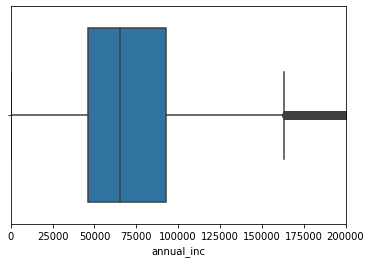

In [11]:
sns.boxplot(float_data['annual_inc'])
mp.xlim(0,200000)

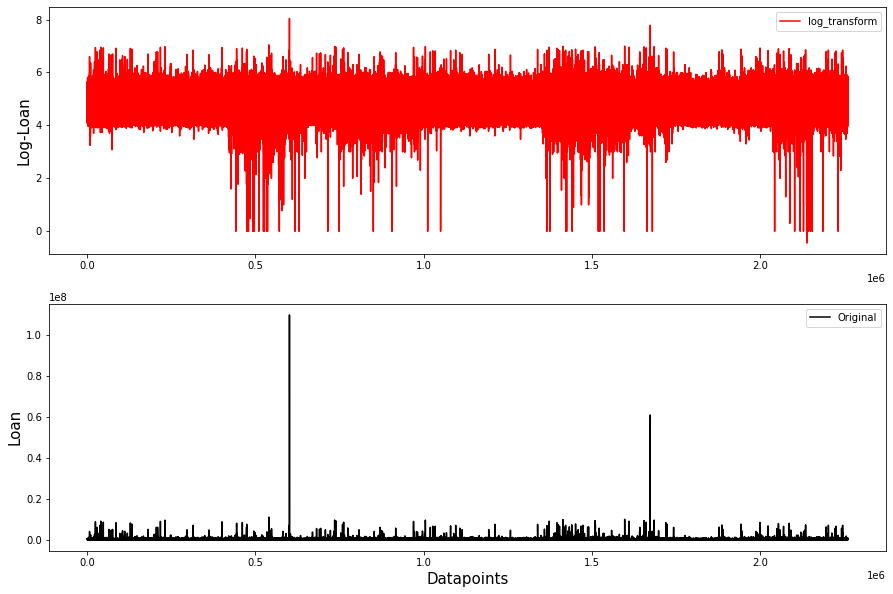

In [12]:
log_transform=(np.log10((float_data['annual_inc']).values))
log_dataframe=pd.DataFrame({'Income':log_transform})
without_log = pd.DataFrame({"Income":float_data['annual_inc'].values})
fig,ax= mp.subplots(2,1,figsize=(15,10))
ax[0].plot(log_transform,color='red',label='log_transform')
ax[1].plot(float_data['annual_inc'].values,color='black',label='Original')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[1].set_xlabel('Datapoints',fontsize=15)
ax[0].set_ylabel('Log-Loan',fontsize=15)
ax[1].set_ylabel('Loan',fontsize=15)
mp.show()
#mp.plot((float_data['annual_inc']).values)

###Log transforming present a clear case that there are too many entries above and below the mean--specially there are quite a few values close to million. This can't be a human error.

In [13]:
float_data['annual_inc'].describe()

count    2.260701e+06
mean     7.799243e+04
std      1.126953e+05
min      0.000000e+00
25%      4.600000e+04
50%      6.500000e+04
75%      9.300000e+04
max      1.100000e+08
Name: annual_inc, dtype: float64

### Some values are off 

### Is this really an outlier? This need more delicate consideration--I have to check the purpose and the loan_amnt

In [14]:
pd.DataFrame(dataframe[['annual_inc','loan_amnt','purpose']].where((dataframe['annual_inc']>5*10**7)).dropna()).reset_index().style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'})

In [15]:
pd.DataFrame(dataframe[['annual_inc','loan_amnt','purpose']].where((dataframe['annual_inc']>5*10**6)).dropna()).reset_index().head(20).style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'})

In [16]:
pd.DataFrame(dataframe[['annual_inc','loan_amnt','purpose']].where((dataframe['annual_inc']>5*10**6)).dropna()).reset_index()['index'].count()

93

### I am still not sure if this an outlier? Anyone can take loan for any purpose--however the annual income reported is huge. Still this is a more subjective decision to remove these entries. For example a person with 9000000.000000 annual income is asking for a loan of 11000.000 for debt_consolidation. Further there are too many such entries-they all can't be outliers.Considering this I will still keep these entries. 

In [17]:
dataframe.head(3).style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'})

In [18]:
temp=dataframe.select_dtypes('object').fillna('')
columns_ob = dataframe.select_dtypes('object').columns
columns_ob

Index(['grade', 'emp_length', 'verification_status', 'issue_d', 'purpose',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d', 'application_type',
       'verification_status_joint', 'sec_app_earliest_cr_line',
       'hardship_status', 'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date'],
      dtype='object')

In [19]:
dataframe[list(columns_ob)] = temp.copy()

In [20]:
list(dataframe.select_dtypes('object').isna().mean().sort_values())

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [21]:
dataframe.head(3).style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'})

In [22]:
obj_data = dataframe.select_dtypes('object')
obj_data.head(3).style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'})

### Some of the object features are of very high cardinality i.e. with many labels. 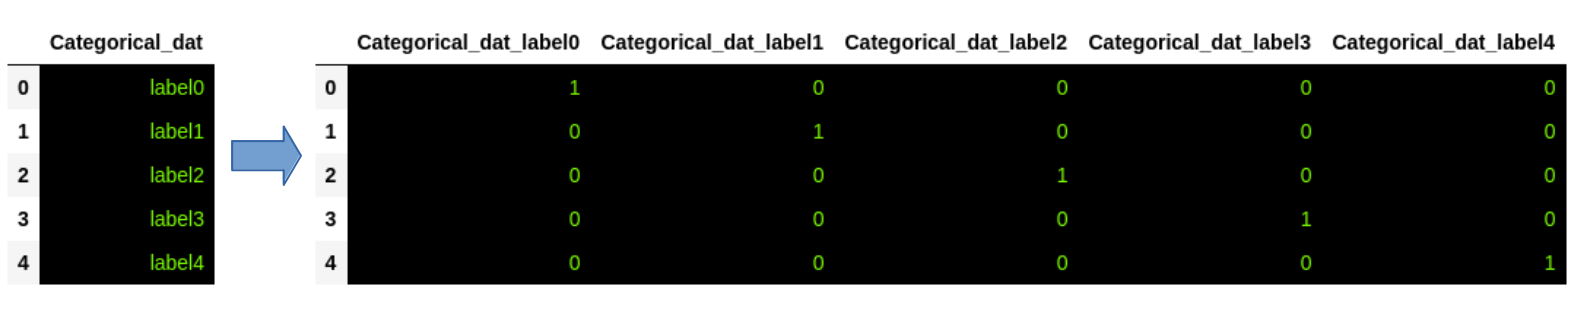

Considering this--one hot encoding will make a feature explosion. The following link and library mentions about some ways to deal with features with very high cardinality. http://contrib.scikit-learn.org/category_encoders/index.html. I can use hashing but the hashing algorithm may put different categories in the same group--might affect the target negatively. Other way around is the target encoding which is explained quite well in the following link--https://maxhalford.github.io/blog/target-encoding/I could have used the mean encoding. However, I decide to follow the Laplace smoothing of the local mean. It is because if there is a very low occurence of a certain label/category of a categorical feature then its local mean cannot be trusted. Then a more heavy emphasis should be given on the global mean.


In [23]:
df_empty = pd.DataFrame({'less_than_'+str(200)+'_counts_categories': [],'greater_than_'+str(200)+'_counts_categories':[]})
unique=[]
for key in list(obj_data.columns):
    unique.append(obj_data[key].nunique())
    
    Count = dict(check_greater(key,'loan_status_binary',dataframe,200))
    #print(pd.DataFrame(Count,index=[0]))
    
    df_empty = pd.concat([df_empty,pd.DataFrame(Count,index=[key]).rename(columns={1:'greater_than_'+str(200)+'_counts_categories',0:'less_than_'+str(200)+'_counts_categories'})])
#pd.DataFrame(Count,index=[key]).rename(columns={1:'greater_than_'+str(200)+'_counts',0:'less_than_'+str(200)+'_counts'})
df_empty = df_empty.fillna(0)

df_empty['unique_category'] = unique
df_unique =df_empty.copy()

In [24]:
df_unique['ratio'] = df_unique['greater_than_200_counts_categories'].values/df_unique['less_than_200_counts_categories'].values

In [25]:
df_unique = df_unique.replace(np.inf,np.nan)
df_unique.style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'})

### It means there are 14 columns with less than 200 counts and all the other columns have higher count. We can work with the local mean too.

In [26]:
vals = df_unique.ratio.values
for i, idx in enumerate(list(df_unique.index)):
    
    #print(idx,type(vals[i]))
    
    if (vals[i] > 2 or np.isnan(vals[i])):
        ### local means can be trusted and the weight is set to 2:
        smooth = additive_smoothing(dataframe,idx,'loan_status_binary',2)
        obj_data[idx+'_encoded'] = obj_data[idx]
        obj_data[idx+'_encoded'] = obj_data[idx+'_encoded'].map(smooth)
    elif vals[i]<=2:
        ### perform smoothing towards the global mean
        print("Performing smoothing towards global mean",vals[i])
        smooth = additive_smoothing(dataframe,idx,'loan_status_binary',100)
        obj_data[idx+'_encoded'] = obj_data[idx]
        obj_data[idx+'_encoded'] = obj_data[idx+'_encoded'].map(smooth)
        
    #obj_data[idx+'_encoded'] = obj_data[idx]
    #obj_data[idx+'_encoded'] = obj_data[idx+'_encoded'].map(smooth)
            
#obj_data

Performing smoothing towards global mean 2.0
Performing smoothing towards global mean 0.028846153846153848
Performing smoothing towards global mean 1.5357142857142858
Performing smoothing towards global mean 2.0
Performing smoothing towards global mean 0.43722943722943725
Performing smoothing towards global mean 2.0
Performing smoothing towards global mean 2.0
Performing smoothing towards global mean 0.5
Performing smoothing towards global mean 0.4918032786885246


In [27]:
dataframe['loan_status_binary']=dataframe['loan_status_binary'].astype(int)

In [28]:
dataframe['loan_status_binary']

0          0
1          0
2          0
3          0
4          0
          ..
2260696    0
2260697    1
2260698    0
2260699    0
2260700    0
Name: loan_status_binary, Length: 2260701, dtype: int64

In [29]:
Ml_data = pd.concat([dataframe.select_dtypes('float64'),dataframe.select_dtypes(int),obj_data.select_dtypes('float64')],axis=1)

In [30]:
Ml_data.head(5).style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'})

In [31]:
(Ml_data.corr()['loan_status_binary'].sort_values())

last_fico_range_high                  -0.599870
out_prncp                             -0.210347
last_pymnt_amnt                       -0.180399
total_pymnt                           -0.140597
fico_range_low                        -0.119437
bc_open_to_buy                        -0.080518
mths_since_recent_inq                 -0.056910
total_rev_hi_lim                      -0.054942
mo_sin_rcnt_tl                        -0.054491
mo_sin_rcnt_rev_tl_op                 -0.054409
tot_cur_bal                           -0.052786
mths_since_recent_bc                  -0.046468
annual_inc_joint                      -0.045568
dti_joint                             -0.042000
revol_bal_joint                       -0.041359
sec_app_mort_acc                      -0.038206
mo_sin_old_rev_tl_op                  -0.035081
mort_acc                              -0.035010
sec_app_open_act_il                   -0.034737
annual_inc                            -0.024734
max_bal_bc                            -0

In [32]:
def find_description(text):
  """" Extract the description from the data dictionary"""
  print("This is the description {}, and this is the key {}".format(df_dict[df_dict['LoanStatNew'].str.startswith(text)==True][['Description']].values, text))

In [33]:
Key_list = ['debt_settlement_flag','settlement_status','settlement_date','settlement_amount','debt_settlement_flag_date','settlement_amount','last_pymnt_d','settlement_date','next_pymnt_d','recoveries','out_prncp','last_pymnt_amnt','last_credit_pull_d','last_fico_range_high','total_pymnt']
for text in Key_list:
  find_description(text)

This is the description [['Flags whether or not the borrower, who has charged-off, is working with a debt-settlement company.']
 ['The most recent date that the Debt_Settlement_Flag has been set\xa0\xa0']], and this is the key debt_settlement_flag
This is the description [['The status of the borrower\x92s settlement plan. Possible values are: COMPLETE, ACTIVE, BROKEN, CANCELLED, DENIED, DRAFT']], and this is the key settlement_status
This is the description [['The date that the borrower agrees to the settlement plan']], and this is the key settlement_date
This is the description [['The loan amount that the borrower has agreed to settle for']], and this is the key settlement_amount
This is the description [['The most recent date that the Debt_Settlement_Flag has been set\xa0\xa0']], and this is the key debt_settlement_flag_date
This is the description [['The loan amount that the borrower has agreed to settle for']], and this is the key settlement_amount
This is the description [['Last m

### Feature leakage:-- leakage is a situation in which a model is built using data which is not available at the time the model will be used to make a prediction. Considering this and after checking the description of the data in the lending club data dictionary--I will drop these features ['issue_d_encoded','total_rec_late_fee','debt_settlement_flag_encoded','settlement_status_encoded','settlement_amount','settlement_date_encoded','debt_settlement_flag_date_encoded','settlement_amount','last_pymnt_d_encoded','settlement_date_encoded','next_pymnt_d_encoded','recoveries','out_prncp','last_pymnt_amnt','last_credit_pull_d_encoded','last_fico_range_high','total_pymnt']as these features may not be available at the time of classification and or may be too indicative of the target value.
### For example the recoveries feature is the "post charge off recovery"---this is only available after a charge off has occured and shouldn't be included in the model development.

In [60]:
pycaret_session = setup(data =Ml_data, fold=3, target = 'loan_status_binary',n_jobs=-1,use_gpu=True,normalize=True,normalize_method='maxabs',ignore_features=['issue_d_encoded','total_rec_late_fee','debt_settlement_flag_encoded','settlement_amount','settlement_date_encoded','int_rate','total_rec_int','debt_settlement_flag_date_encoded','last_pymnt_d_encoded','next_pymnt_d_encoded','recoveries','out_prncp','last_pymnt_amnt','last_credit_pull_d_encoded','last_fico_range_high','total_pymnt','settlement_status_encoded'])

Description               Value
0                               session_id                2952
1                                   Target  loan_status_binary
2                              Target Type              Binary
3                            Label Encoded          0: 0, 1: 1
4                            Original Data       (2260701, 98)
5                           Missing Values               False
6                         Numeric Features                  79
7                     Categorical Features                   1
8                         Ordinal Features               False
9                High Cardinality Features               False
10                 High Cardinality Method                None
11                   Transformed Train Set       (1582490, 80)
12                    Transformed Test Set        (678211, 80)
13                      Shuffle Train-Test                True
14                     Stratify Train-Test               False
15                          Fold Generator     StratifiedKFold
16                             Fold Number                   3
17                                CPU Jobs                  -1
18                                 Use GPU                True
19                          Log Experiment               False
20                         Experiment Name    clf-default-name
21                                     USI                8079
22                         Imputation Type              simple
23          Iterative Imputation Iteration                None
24                         Numeric Imputer                mean
25      Iterative Imputation Numeric Model                None
26                     Categorical Imputer            constant
27  Iterative Imputation Categorical Model                None
28           Unknown Categoricals Handling      least_frequent
29                               Normalize                True
30                        Normalize Method              maxabs
31                          Transformation               False
32                   Transformation Method                None
33                                     PCA               False
34                              PCA Method                None
35                          PCA Components                None
36                     Ignore Low Variance               False
37                     Combine Rare Levels               False
38                    Rare Level Threshold                None
39                         Numeric Binning               False
40                         Remove Outliers               False
41                      Outliers Threshold                None
42                Remove Multicollinearity               False
43             Multicollinearity Threshold                None
44                              Clustering               False
45                    Clustering Iteration                None
46                     Polynomial Features               False
47                       Polynomial Degree                None
48                    Trignometry Features               False
49                    Polynomial Threshold                None
50                          Group Features               False
51                       Feature Selection               False
52            Features Selection Threshold                None
53                     Feature Interaction               False
54                           Feature Ratio               False
55                   Interaction Threshold                None
56                           Fix Imbalance               False
57                    Fix Imbalance Method               SMOTE

In [61]:
sorted(list(Ml_data.columns))#.str.contains(regex='Settlment')

['acc_now_delinq',
 'acc_open_past_24mths',
 'all_util',
 'annual_inc',
 'annual_inc_joint',
 'application_type_encoded',
 'bc_open_to_buy',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'debt_settlement_flag_date_encoded',
 'debt_settlement_flag_encoded',
 'deferral_term',
 'delinq_2yrs',
 'delinq_amnt',
 'disbursement_method_encoded',
 'dti',
 'dti_joint',
 'earliest_cr_line_encoded',
 'emp_length_encoded',
 'fico_range_low',
 'grade_encoded',
 'hardship_amount',
 'hardship_last_payment_amount',
 'hardship_status_encoded',
 'il_util',
 'initial_list_status_encoded',
 'inq_fi',
 'inq_last_12m',
 'inq_last_6mths',
 'int_rate',
 'issue_d_encoded',
 'last_credit_pull_d_encoded',
 'last_fico_range_high',
 'last_pymnt_amnt',
 'last_pymnt_d_encoded',
 'loan_amnt',
 'loan_status_binary',
 'max_bal_bc',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since

### I will start with logistic regression to perform the classification of 'charged off status'.

In [62]:
logistic = create_model('lr')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8814  0.7253  0.0259  0.5412  0.0494  0.0389  0.0986
1       0.8811  0.7265  0.0239  0.5160  0.0458  0.0356  0.0914
2       0.8811  0.7254  0.0249  0.5159  0.0474  0.0369  0.0931
Mean    0.8812  0.7257  0.0249  0.5243  0.0475  0.0371  0.0943
SD      0.0001  0.0006  0.0008  0.0119  0.0015  0.0014  0.0031

The machine learning model has been built and tuned. various metrics have been spitted out by pycaret computed over a confusion matrix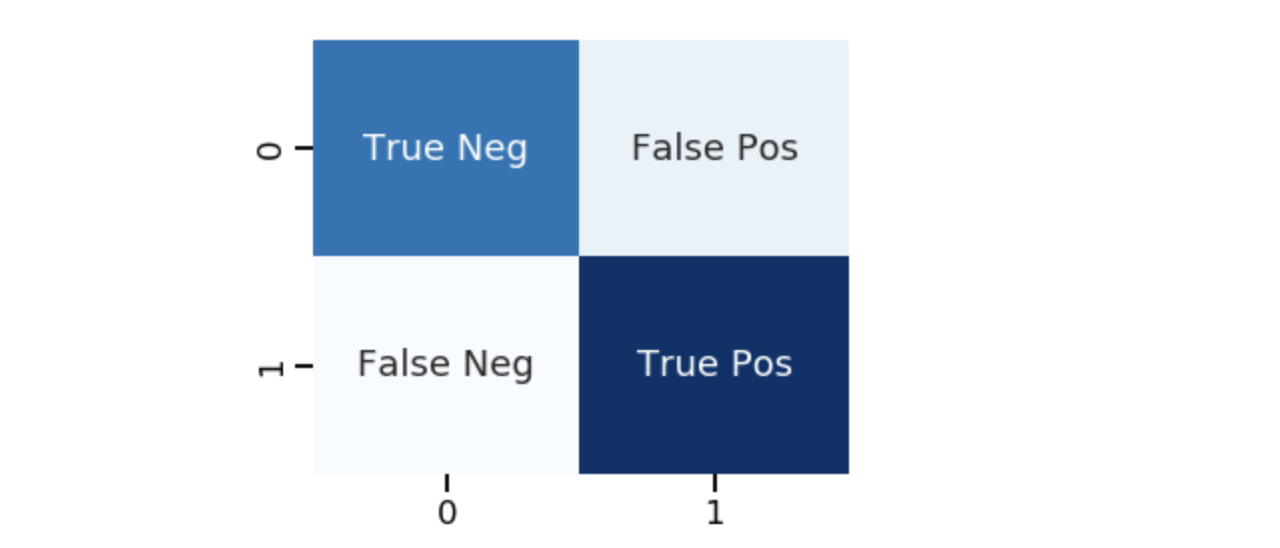. For example Accuracy = $\frac{\text{Total number of correct predictions}}{\text{Total predictions made}}$, Precision = $\frac{\text{True positive}}{\text{True positive + False positive}}$, Recall = $\frac{\text{True positive}}{\text{True positive + False negative}}$, F1 score= $\frac{\text{2* Precision*Recall}}{\text{Precision+Recall}}$, MCC = $\frac{TP*TN-FP*FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN}}$. Considering this I will optimize for Recall as I don't want someone to be categorized as non defaulter even though he/she is going to do a default.






In [63]:
tuned_lr = tune_model(logistic,n_iter=3, optimize='recall')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.6617  0.7261  0.6625  0.2092  0.3180  0.1673  0.2166
1       0.6619  0.7272  0.6662  0.2100  0.3193  0.1689  0.2188
2       0.6607  0.7263  0.6634  0.2088  0.3176  0.1667  0.2161
Mean    0.6614  0.7265  0.6640  0.2093  0.3183  0.1676  0.2172
SD      0.0005  0.0005  0.0016  0.0005  0.0007  0.0009  0.0012

### After hyper parameter tuning for the logistic regression---a signficant improvement in the recall value. I could have went further and let it run for more number of iterations but somehow the computation collapse.

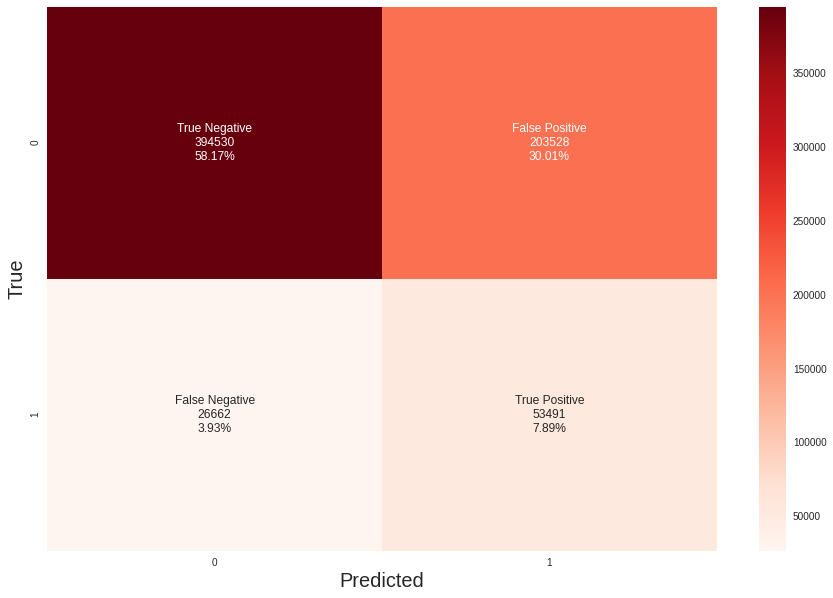

In [64]:
from sklearn.metrics import confusion_matrix
get_config(variable="y_test")
X_trianing = get_config(variable="X_train")
Y_training = get_config(variable="y_train")
X_test = get_config(variable="X_test")
Y_test = get_config(variable="y_test")
labels = ['True Negative','False Positive','False Negative','True Positive']
cf_matrix = confusion_matrix(Y_test.values,tuned_lr.predict(X_test))
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
mp.figure(figsize=(15,10))
sns.heatmap(cf_matrix,annot=labels,fmt='',cmap='Reds',cbar=True)
mp.xlabel(r'Predicted',fontsize=20)
mp.ylabel(r'True',fontsize=20)
mp.show()


### We can extract the training and testing set used by pycaret_test_2 tuple to feed on to the confusion_matrix function of sklearn to do the computation. We can also compute the precision and recall curve and the feature importance curves using our favorite plotting libraries. I will plot the feature importance and compute the Shap values. 

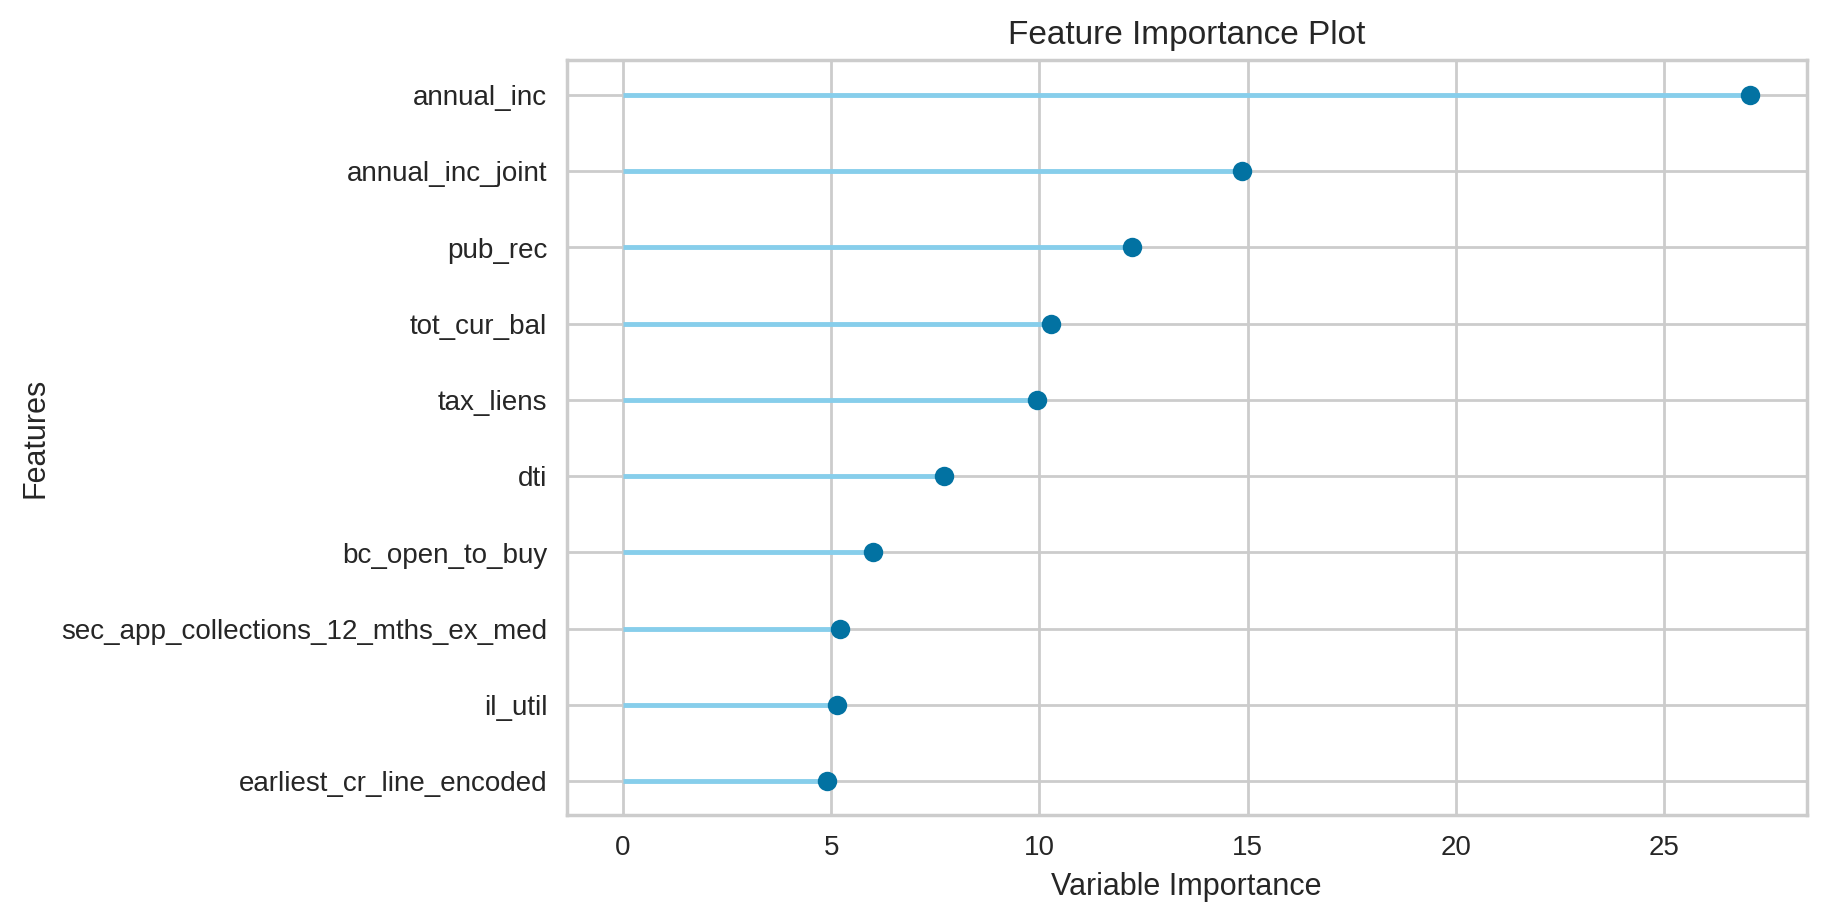

In [65]:
#feature_importance = abs(tuned_lr.coef_[0])
#feature_importance
#feature_importance = 100.0 * (feature_importance / feature_importance.max())
#sorted_idx = np.argsort(feature_importance)
#pos = np.arange(sorted_idx.shape[0]) + .5

#featfig = mp.figure(figsize=(35,20))
#featax = featfig.add_subplot(1, 1, 1)
#featax.barh(pos, feature_importance[sorted_idx], align='center')
#featax.set_yticks(pos)
#featax.set_yticklabels(np.array(X_test.columns)[sorted_idx])
#featax.set_xlabel('Relative Feature Importance')
#mp.tight_layout()   
#mp.show()
plot_model(tuned_lr, plot = 'feature',scale=2)



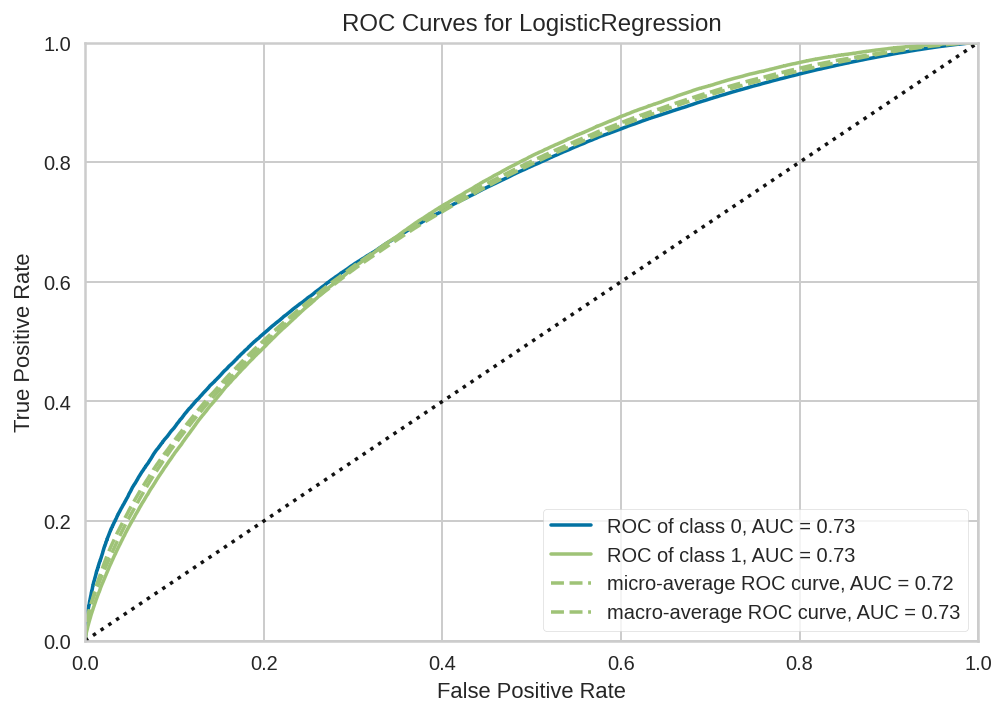

In [66]:


plot_model(tuned_lr, plot = 'auc',scale=2)



In [67]:
!pip install shap

### Now I will try some ensemble learning techniques. Because of their adaptive nature they should be able to perform better by learning from successive weak models. The first in the list is light gradient boosting.

In [68]:
lgbm = create_model('lightgbm')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8818  0.7501  0.0176  0.6252  0.0343  0.0279  0.0907
1       0.8817  0.7505  0.0161  0.6214  0.0314  0.0255  0.0863
2       0.8817  0.7503  0.0184  0.6078  0.0357  0.0289  0.0908
Mean    0.8817  0.7503  0.0174  0.6181  0.0338  0.0275  0.0892
SD      0.0000  0.0002  0.0010  0.0075  0.0018  0.0014  0.0021

In [69]:
tuned_lgbm = tune_model(lgbm,n_iter=3, optimize='recall')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8781  0.7326  0.0485  0.4009  0.0866  0.0625  0.1053
1       0.8781  0.7336  0.0501  0.4046  0.0892  0.0647  0.1079
2       0.8782  0.7317  0.0500  0.4078  0.0892  0.0648  0.1086
Mean    0.8782  0.7326  0.0496  0.4044  0.0883  0.0640  0.1072
SD      0.0001  0.0008  0.0007  0.0028  0.0012  0.0011  0.0014

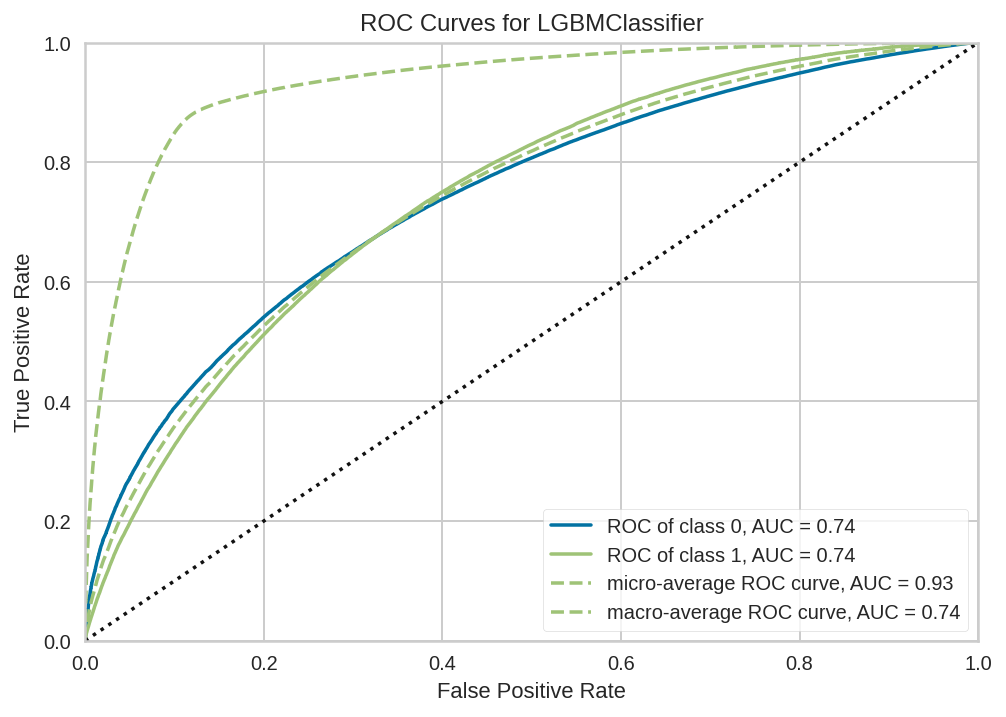

In [70]:
plot_model(tuned_lgbm,plot='auc',scale=2)

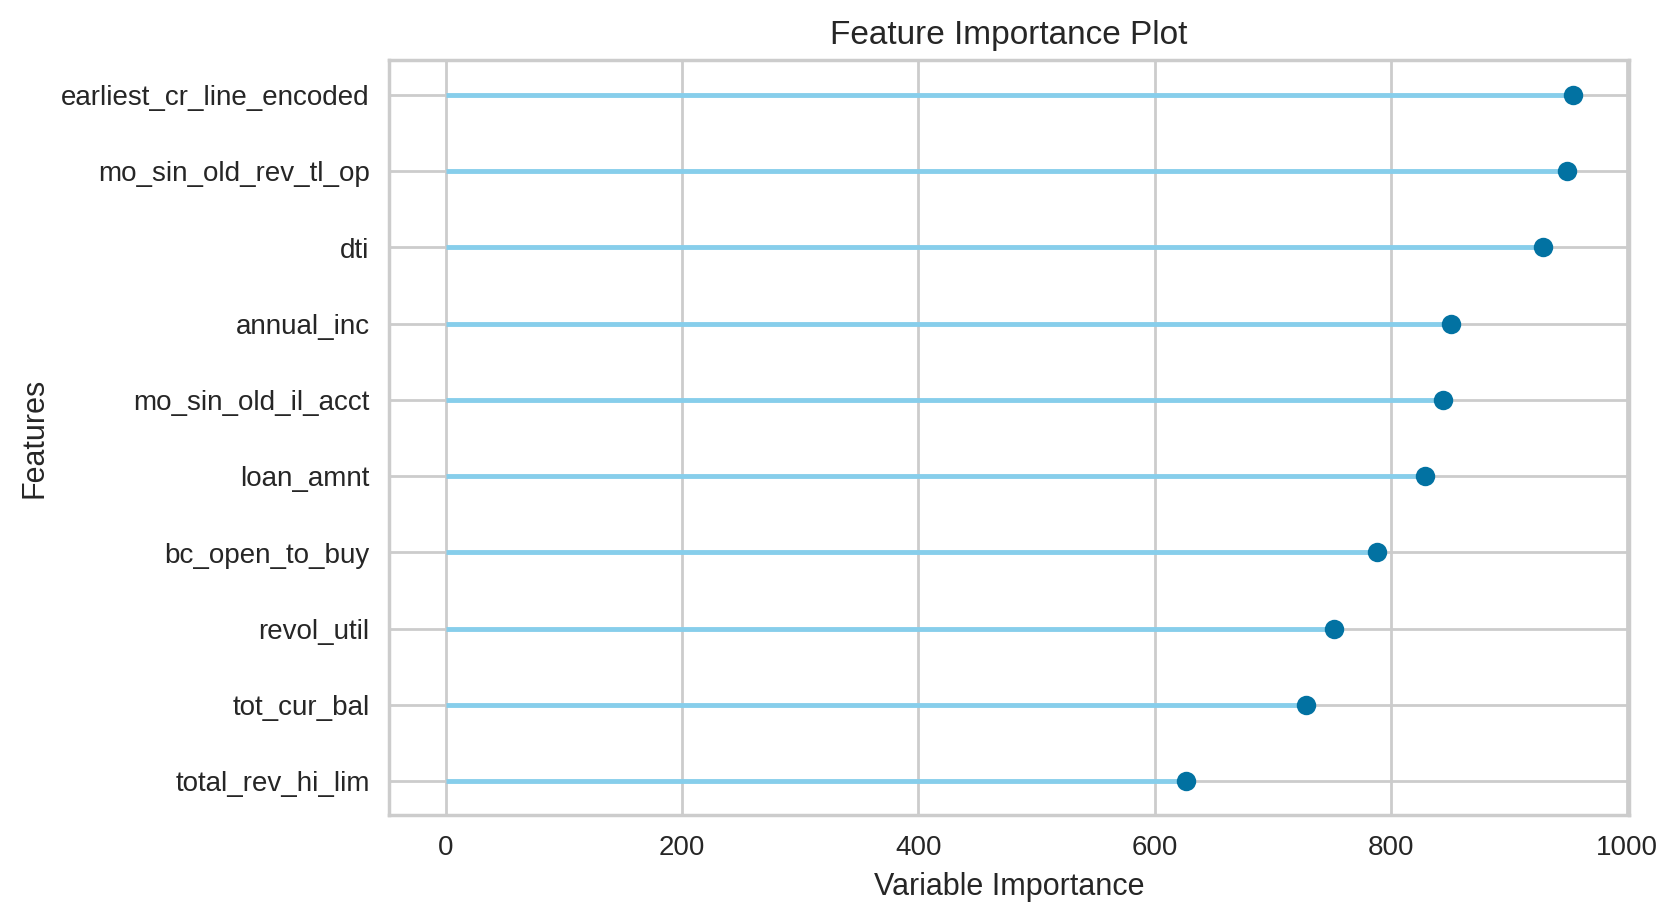

In [71]:
plot_model(tuned_lgbm, plot='feature',scale=2)

### Light graient boosting gives more importance to total interest receive to this day. But again Shap values may show some other interesting detail.

In [72]:
xgboost = create_model('xgboost')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8817  0.7513  0.0278  0.5620  0.0529  0.0422  0.1052
1       0.8816  0.7510  0.0264  0.5539  0.0503  0.0399  0.1013
2       0.8815  0.7507  0.0280  0.5440  0.0533  0.0421  0.1031
Mean    0.8816  0.7510  0.0274  0.5533  0.0522  0.0414  0.1032
SD      0.0001  0.0002  0.0007  0.0074  0.0013  0.0011  0.0016

In [73]:
xgboost_tune = tune_model(xgboost,n_iter=6, optimize='recall')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.2395  0.7493  0.9883  0.1342  0.2363  0.0337  0.1247
1       0.2402  0.7491  0.9888  0.1343  0.2366  0.0341  0.1256
2       0.2411  0.7492  0.9872  0.1343  0.2365  0.0340  0.1248
Mean    0.2402  0.7492  0.9881  0.1343  0.2365  0.0339  0.1250
SD      0.0006  0.0001  0.0006  0.0001  0.0001  0.0001  0.0004

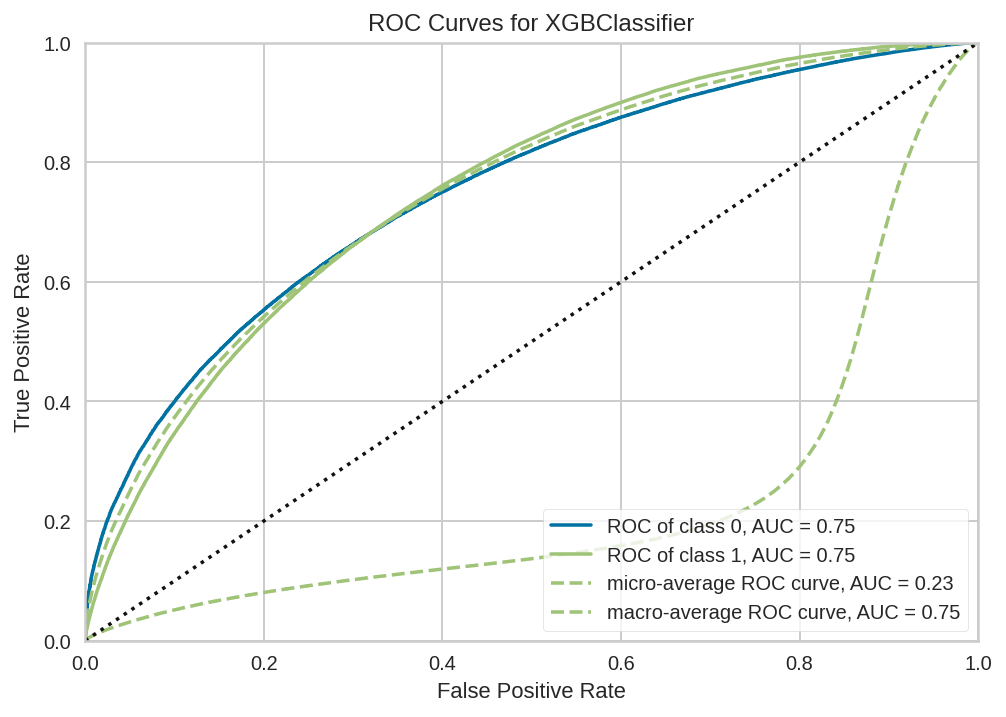

In [74]:
plot_model(xgboost_tune,plot='auc',scale=2)

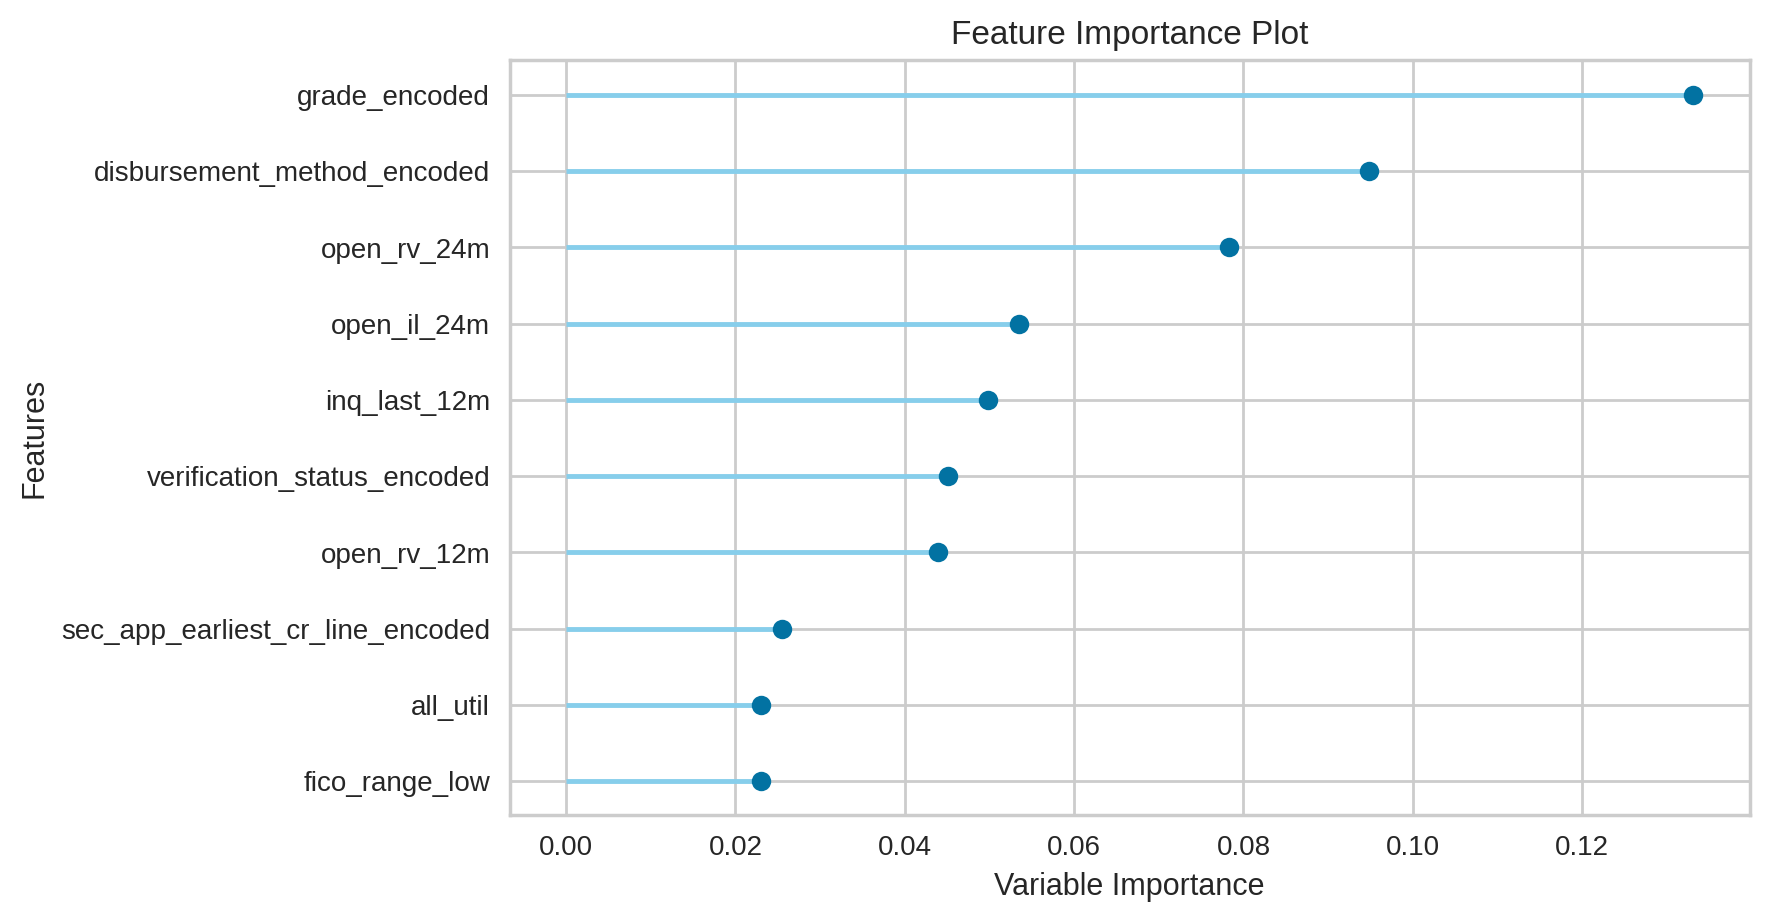

In [75]:
plot_model(xgboost_tune, plot='feature',scale=2)

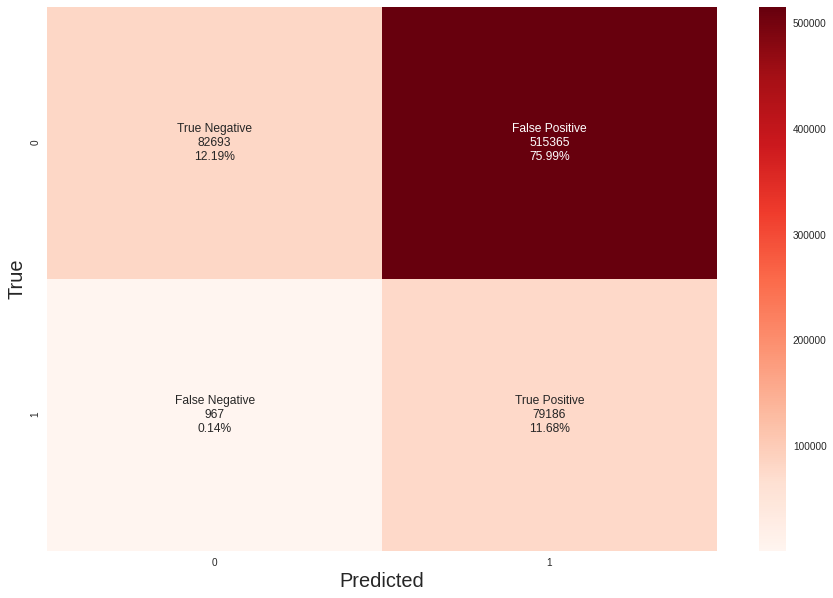

In [76]:
cf_matrix = confusion_matrix(Y_test.values,xgboost_tune.predict(X_test))
labels = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
mp.figure(figsize=(15,10))
sns.heatmap(cf_matrix,annot=labels,fmt='',cmap='Reds',cbar=True)
mp.xlabel(r'Predicted',fontsize=20)
mp.ylabel(r'True',fontsize=20)
mp.show()

### XGBOOST appears to give the best recall rate meaning that this model will not falsely put defaulters under the non-defaulters category. Further its auc value is also very good. 

### At last I will initiate a new pycarert session and finish the modeling with categorical boosting or CatBoost algorithm. CatBoost is able to handle categorical features--so I don't have to convert those features before feeding into the model. Since the model is crashing on google collab. I will train catboost in a separate notebook and in the same notebook I will see the interpretation of CatBoost model too.

##How much has each feature value contributed to the prediction compared to the average prediction?
### The answer to this question lies in the Shap values--which essentially tells how much a change in feature will drive the output away from the average prediction. A typical example of the house price prediction is given here https://christophm.github.io/interpretable-ml-book/shap.html which explains the idea quite well. For linear model the driver which will move the output away from average will be the weight times the feature value but for non-linear model this is not straightforward to answer. The Shap values are model agnostic and exactly explains the same.

In [77]:
#interpret_model(tuned_lgbm)

In [78]:
#interpret_model(xgboost_tune)

In [79]:
import shap

In [80]:
explainer = shap.TreeExplainer(xgboost_tune,approximate=True)
shap_values = explainer.shap_values(X_trianing[0:5000])

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
#shap.force_plot(explainer.expected_value[1], shap_values[1], X_trianing[0:5000])

In [81]:
shap.initjs()
idx = list(X_trianing[0:5000].index)
shap.force_plot(explainer.expected_value, shap_values[20], X_trianing.loc[idx[20]],feature_names=X_trianing.columns)

### SHAP values has their origin in the game theory. The “game” here is the prediction task for a single instance of the dataset. The “players” are the feature values of the instance that collaborate to play the game (predict a value)--i.e. the loan is going to get charged off or not. 

### In short Shapley values correspond to the contribution of each feature towards pushing the prediction away from the expected value of the model outcome.

### The above analysis was for shap values for each feature of every observation, it is possible to get a global interpretation using Shapley values by looking at it in a combined form.



In [82]:
shap.summary_plot(shap_values, features=X_trianing[0:5000], feature_names=X_trianing[0:5000].columns)

### We can check the loan description in the data dictionary for understanding them further

In [83]:
df_dict = pd.read_csv('/content/drive/My Drive/Lending_club_dictionary.csv',encoding='ISO-8859-1')

In [84]:
def find_description(text):
  """" Extract the description from the data dictionary"""
  print("This is the description {}, and this is the key {}".format(df_dict[df_dict['LoanStatNew'].str.startswith(text)==True][['Description']].values, text))

In [85]:
#find_description('total_rec_late_fee')
find_description('purpose')

This is the description [['A category provided by the borrower for the loan request. ']], and this is the key purpose


###Clearly the features like interest rate depends on the grade of the customers. This I also observed while doing the EDA--it in turn means that the grade of a customer is a very good indicator of the customer doing a default or not in future.  Clearly Shap values gives much more information than the simple weightage given to the model features.

### The top features identified by the Xgboost are informative as all of them makes sense. For example the less interest rate corresponds to a better grade and consequently to a less probability of doing a default. 